In [182]:
import pandas as pd
import numpy as np
from packages import wrappers, models, ta
from sklearn.linear_model import LinearRegression

In [183]:
asset_df = wrappers.get_df_from_cryptowatch(pair='dogeusd')
asset_df

,Open,High,Low,Close,Volume,QuoteVolume
Date,,,,,,
2019-12-19,0.002100,0.037000,0.002100,0.002500,1.665000e+04,2.989096e+02
2019-12-20,0.002052,0.002300,0.002000,0.002020,6.796013e+05,1.450382e+03
2019-12-21,0.002100,0.002100,0.002100,0.002100,7.484094e+05,1.571618e+03
2019-12-22,0.002070,0.002103,0.001953,0.002085,1.614581e+06,3.314817e+03
2019-12-23,0.002121,0.002306,0.001997,0.002232,1.616856e+05,3.430913e+02
...,...,...,...,...,...,...
2021-08-15,0.294072,0.349941,0.286975,0.340500,2.573110e+08,8.097295e+07
2021-08-16,0.340214,0.351855,0.309268,0.319699,1.999215e+08,6.659487e+07
2021-08-17,0.319326,0.339900,0.294692,0.299072,1.418677e+08,4.559163e+07


In [184]:
day_predicting = '2021-08-18'
num_days = 365
features = ['Close', 'Volume', 'ATR_14', 'OBV']
# features = ['Volume', 'ATR_14', 'OBV']

In [185]:
prepped_df = models.add_TA(asset_df)

In [186]:
prepped_df = models.prepare_for_model(asset_df, day_predicting, num_days, features=features, target='Close')

In [187]:
prepped_df

,Target,Close,Volume,ATR_14,OBV
Date,,,,,
2020-08-17,0.003511,0.003579,3.919169e+07,0.000221,2.311237e+08
2020-08-18,0.003403,0.003511,3.110789e+07,0.000224,2.000158e+08
2020-08-19,0.003442,0.003403,4.180986e+07,0.000222,1.582060e+08
2020-08-20,0.003373,0.003442,2.502715e+07,0.000215,1.832331e+08
2020-08-21,0.003427,0.003373,2.377168e+07,0.000214,1.594615e+08
...,...,...,...,...,...
2021-08-13,0.294633,0.286897,9.818225e+07,0.024991,2.026998e+10
2021-08-14,0.340500,0.294633,1.694647e+08,0.025029,2.043944e+10
2021-08-15,0.319699,0.340500,2.573110e+08,0.027739,2.069675e+10


# Analysis

https://www.machinelearningplus.com/time-series/time-series-analysis-python/ <br>

This is a guide to applying time-series to machine learning, it could be worth exploring and is explored a little in this cell.

Here we're checking the autocorrelation (https://en.wikipedia.org/wiki/Autocorrelation) and partial autocorrelation (https://en.wikipedia.org/wiki/Partial_correlation) of the data where each row is represented by a day (can change if we decide to use hour candles). Lets assume that the last value above the blue region is 30. To my understanding, if I try predicting the price of btc, I should use the last 30 days (month) to do so.

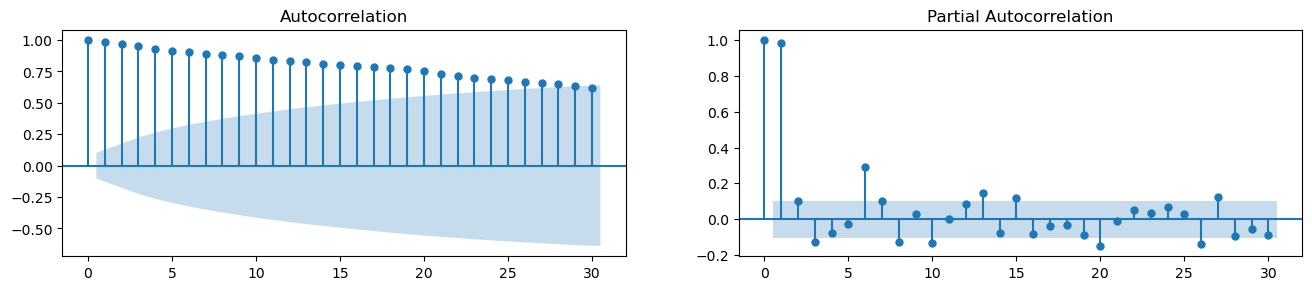

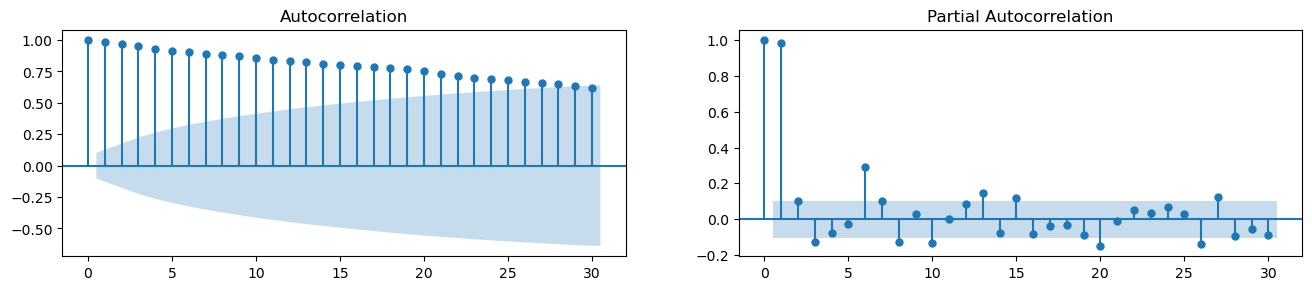

In [223]:
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf_50 = acf(prepped_df.Close, nlags=50)

fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)

plot_acf(prepped_df.Close, lags=30, ax=axes[0])
plot_pacf(prepped_df.Close, lags=30, ax=axes[1])

### Approximate and Sample Entropy

https://en.wikipedia.org/wiki/Approximate_entropy <br>
https://en.wikipedia.org/wiki/Sample_entropy

These are used to see how forecastable the data is. The rand_small and rand_big values represent the entropy values for different data sizes

In [235]:
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

In [240]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

In [243]:
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

print(ApEn(prepped_df.Close, m=2, r=0.2*np.std(prepped_df.Close)))
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small)))
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))
print()
print(SampEn(prepped_df.Close, m=2, r=0.2*np.std(prepped_df.Close)))
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))

0.17221246919443534
0.3302840511101084
0.6937568652891031

0.03415686083092254
1.3862943611198906
2.495269436823547


# Regression

In [188]:
Xtrain, Xtest, ytrain, ytest = models.get_train_test(prepped_df)
display(Xtrain, ytrain, Xtest, ytest)

,Close,Volume,ATR_14,OBV
Date,,,,
2020-08-17,0.003579,3.919169e+07,0.000221,2.311237e+08
2020-08-18,0.003511,3.110789e+07,0.000224,2.000158e+08
2020-08-19,0.003403,4.180986e+07,0.000222,1.582060e+08
2020-08-20,0.003442,2.502715e+07,0.000215,1.832331e+08
2020-08-21,0.003373,2.377168e+07,0.000214,1.594615e+08
...,...,...,...,...
2021-08-12,0.264089,1.562704e+08,0.024943,2.017180e+10
2021-08-13,0.286897,9.818225e+07,0.024991,2.026998e+10
2021-08-14,0.294633,1.694647e+08,0.025029,2.043944e+10


,Target
Date,
2020-08-17,0.003511
2020-08-18,0.003403
2020-08-19,0.003442
2020-08-20,0.003373
2020-08-21,0.003427
...,...
2021-08-12,0.286897
2021-08-13,0.294633
2021-08-14,0.340500


,Close,Volume,ATR_14,OBV
Date,,,,
2021-08-17,0.299072,1.418677e+08,0.029971,2.035497e+10


,Target
Date,
2021-08-17,0.30315


# Backtester class

In [189]:
class Backtester:
    def __init__(self, start_date='', end_date='', step=1, num_days=365):
        self.num_days = num_days

In [190]:
def get_pct_change(initial, final):
    return (final - initial) / initial * 100

# Training model

In [191]:
lr = LinearRegression().fit(Xtrain, ytrain)
prediction = lr.predict(Xtest)[0][0]
actual = ytest.iloc[0, 0]
predicted_pct = round(get_pct_change(prepped_df['Close'].iloc[[-1]][0], prediction), 2)
actual_pct = round(get_pct_change(prepped_df['Close'].iloc[[-1]][0], actual), 2)

In [192]:
print('Prediction:', prediction, 'or', predicted_pct, '%')
print('Actual:', actual, 'or', actual_pct, '%')

Prediction: 0.2971844410932007 or -0.63 %
Actual: 0.30315 or 1.36 %


In [193]:
# display(prediction)
# display(actual)

# Model performance

In [195]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(ytest, prediction))

TypeError: Singleton array 0.2971844410932007 cannot be considered a valid collection.

# Testing Documentation

In [194]:
# ?models.get_train_test